# Health and Economic Analysis

In [26]:
%matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import difflib
import re
#import seaborn as sns

Import Local Authority to NUTS key // Source: http://ec.europa.eu/eurostat/web/nuts/local-administrative-units

In [3]:
key = pd.read_excel('key.xlsx',sheetname='UK', usecols=['NUTS3_13','LAU1_NAT_CODE_NEW'])
key = key.drop_duplicates()
key.columns = ['NUTS3','Area Code']
key = key.set_index('Area Code')

   Area Code for South Oxfordshire (Contains Chargrove)

In [4]:
ac = 'E07000179'

Import Gross Value Added // Source: https://www.ons.gov.uk/economy/grossvalueaddedgva/datasets/regionalgrossvalueaddedincomeapproach

In [22]:
gva = pd.read_excel('gva.xls',sheetname='Table 1', skiprows=1)
gva = gva[gva['NUTS level'].str.contains("NUTS3") == True]
gva = gva.set_index('NUTS code')
gva = key.merge(gva, left_on='NUTS3', right_index=True, how='left')
gva.drop(gva.columns[[0,1,2,3,4,5,6,7,8,9,10,11,21]], axis=1, inplace=True)
gva = gva[gva.index.str.contains(ac) == True]
gva = gva.transpose()
gva.columns = ['Gross Value Added']
bs = gva.iloc[0]['Gross Value Added']
gva['GVA % Change'] = ((gva['Gross Value Added'] - bs)/bs) * 100
xi = [2006,2007,2008,2009,2010,2011,2012,2013,2014]
gva = gva.set_index([xi],drop=True)
gva.head()

,Gross Value Added,GVA % Change
2006,15328.0,0.000000
2007,16138.0,5.284447
2008,16710.0,9.016180
2009,16627.0,8.474687
2010,17150.0,11.886743


Import UK Health Data // Source: http://www.phoutcomes.info/public-health-outcomes-framework#page/9/gid/1000049/pat/6/par/E12000004/ati/101/are/E06000015/nn/nn-1-E06000015

In [6]:
healthd = pd.read_excel('health.xlsx',sheetname='District & UA')
healthi = pd.read_excel('health.xlsx',sheetname='Indicator Metadata')

Selected Indicator

In [7]:
Id = '1.01ii'

ind = healthi[healthi['Indicator'].str.contains('{} '.format(Id)) == True]
nm = ind.iloc[0]['Indicator']
unit = ind.iloc[0]['Unit']

#Print out information about selected indicator.
ind

,Indicator,Definition,Value type,Unit,Indicator number,Data quality,Rationale,Policy,Data source,Indicator source,...,Standard population/values,Frequency,Confidence interval details,Disclosure control,Rounding,Caveats,Notes,Copyright,Data re-use,Links
1,1.01ii - Children in low income families (unde...,Percentage of children in low income families ...,Proportion,%,1.01ii,NaN,Child poverty is an important issue for public...,NaN,HM Revenue and Customs (Personal Tax Credits: ...,HM Revenue and Customs (Personal Tax Credits: ...,...,NaN,Annual (October),NaN,Numerator and denominator data have been round...,Numerators and denominators have been rounded.,For National Statistics data on child poverty ...,Denominator values are taken from the HM Reven...,HM Revenue and Customs,NaN,'A New Approach to Child Poverty: Tackling the...


In [23]:
# Select indicator from main dataset
data = healthd[healthd['Indicator'].str.contains('{} '.format(Id)) == True]
data = data[[1,4,6]]

# Get list of time periods
xx = data[[0]]
xx = xx.drop_duplicates()
xl = xx['Time Period'].tolist()

# Loop to create column for each year
for x in range(len(xl)):
    inputs = data[data['Time Period'].str.contains(xl[x]) == True]
    inputs = inputs.drop('Time Period', 1)
    
    # Average male and female values
    inputs = inputs.groupby(inputs['Area Code']).mean()
    inputs.columns = [xl[x]]
    if x == 0:
        datar = inputs
    else:
        datar = datar.merge(inputs, left_index=True, right_index=True, how='left')

# Select data for South Oxfordshire
datar = datar[datar.index.str.contains(ac) == True]
datar = datar.transpose()
datar.columns = ['Children LIF']
bl = datar.iloc[0]['Children LIF']
datar['Child LIF % Change'] = ((datar['Children LIF'] - bl)/bl) * -100
datar = datar.set_index([xi],drop=True)
datar

,Children LIF,Child LIF % Change
2006,8.500497,-0.000000
2007,8.527595,-0.318789
2008,8.151093,4.110384
2009,8.768804,-3.156379
2010,8.729216,-2.690662
2011,8.494285,0.073077
2012,7.775804,8.525294
2013,7.700000,9.417056
2014,8.300000,2.358645


Merge Data Sets

In [24]:
df = gva.merge(datar, left_index=True, right_index=True, how='outer')
df

,Gross Value Added,GVA % Change,Children LIF,Child LIF % Change
2006,15328.0,0.000000,8.500497,-0.000000
2007,16138.0,5.284447,8.527595,-0.318789
2008,16710.0,9.016180,8.151093,4.110384
2009,16627.0,8.474687,8.768804,-3.156379
2010,17150.0,11.886743,8.729216,-2.690662
2011,17911.0,16.851514,8.494285,0.073077
2012,18680.0,21.868476,7.775804,8.525294
2013,19592.0,27.818372,7.700000,9.417056
2014,20780.0,35.568894,8.300000,2.358645


Plot Graph

<IPython.core.display.Javascript object>


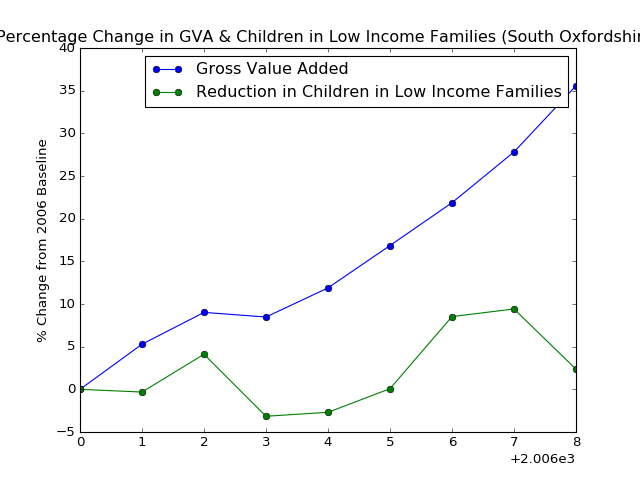

In [25]:
plt.figure()
plt.plot(df['GVA % Change'], '-o', df['Child LIF % Change'], '-o');
plt.gca().set_title('Percentage Change in GVA & Children in Low Income Families (South Oxfordshire)');
plt.gca().set_ylabel('% Change from 2006 Baseline');
plt.gca().legend(['Gross Value Added','Reduction in Children in Low Income Families']);